<a href="https://colab.research.google.com/github/volgasezen/di504/blob/main/Lab1/Intro_to_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="margin-bottom:0">IS 584: Deep Learning for Text Analytics</h1>
<br>
<h3 style="margin-top:0">Lab 3 / Part 2: News Article Classification with PyTorch</h2>
<h4 style="margin-top:0">Given by Volga Sezen</h4>
<i>Thanks to Ayberk Aydın and Arif Ozan Kızıldağ for the feedback.</i>
<br>

-----------

## Importing Packages

In [ ]:
!pip install torch==2.3.1 --index-url https://download.pytorch.org/whl/cu121 --no-dependencies -q
!pip install torchtext -q

In [ ]:
import torch

print(f'torch version: {torch.__version__}')

torch version: 2.3.1+cu121


## torchtext (depracated)

Aside from scientific computing, PyTorch has many utilities for handling data for machine learning and deep learning tasks. You can sample, shuffle, split and batch data as well as apply transformations on them.

Since the development of ``torchtext`` stopped, the most recent version of pytorch it can run with is 2.3.1, hence when running on colab the following commands has to be executed.

To be able to access the AG_NEWS dataset we will use the `datasets` library of HuggingFace. It has its own dataset structure, but we will be converting it into a machine-readable form with data utilities.

In [ ]:
!pip install datasets -q
from datasets import load_dataset

ds = load_dataset("fancyzhx/ag_news")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [ ]:
import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy')

/usr/local/lib/python3.11/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [ ]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(ds['train']['text']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
print("Unique tokens in TEXT vocabulary:",len(vocab))

Unique tokens in TEXT vocabulary: 110933


In [ ]:
text_transform = lambda x: [vocab[token] for token in tokenizer(x)]

# Print out the output of text_transform

test_input = "A sentence in English probably won't contain the word 'hendese'."

print(f"Input to the text_transform: {test_input}")
print(f"Output of the text_transform: {text_transform(test_input)}")

Input to the text_transform: A sentence in English probably won't contain the word 'hendese'.
Output of the text_transform: [46, 3668, 8, 1879, 1758, 2500, 250, 6808, 1, 2518, 75, 0, 75, 3]


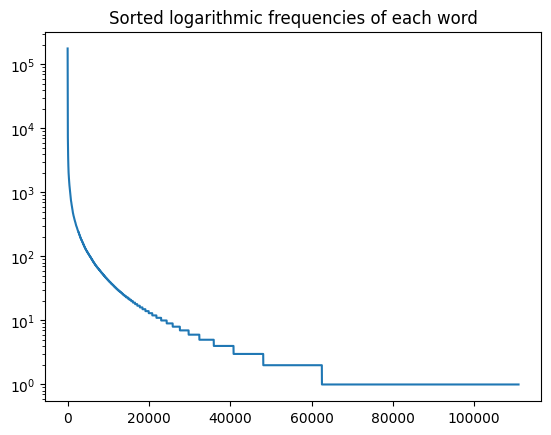

In [ ]:
import itertools
from collections import Counter, OrderedDict

words = list(itertools.chain.from_iterable(yield_tokens(ds['train']['text'])))

counter = Counter(words)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)

frequencies = [x[1] for x in sorted_by_freq_tuples]

plt.plot(frequencies)
plt.title('Sorted logarithmic frequencies of each word')
# plt.xscale('log')
plt.yscale('log')

This function does the following:

* Iterates over each row in the batch. (Batch size is defined later.)
* Tokenizes the "text" column
* Calculates the length of the text
* Turns the text, label and "checkpoints" to tensors

Since we use "extend" method of lists, we will have one giant list. To distinguish one sentence from another we need "checkpoints" based on the length of each sentence.

In [ ]:
def collate(batch):
    texts, labels, offsets = [], [], [0]

    for item in batch:
        text, label = item.values()
        texts.extend(text_transform(text))
        offsets.append(len(text_transform(text)))
        labels.append(label)

    texts = torch.tensor(texts)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=-1)
    labels = torch.tensor(labels)

    return texts, labels, offsets

We can use this collate function inside the DataLoader class. Here we can define the dataset, batch size, and control shuffling.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(ds['train'],
                          batch_size=16,
                          shuffle=False,
                          collate_fn = collate)

next(iter(train_loader))

(tensor([   445,    572,   2057,  50436,   1196,   1718,      1,   1380,     14,
             30,     15,     30,      5,   4033,      5,  10267,      2,    445,
            420,     22,  95259,      7,   8377,      5,  39309,      2,     45,
           4736,   3034,    372,      3,  17829,   5251,   6386,   7993,  10805,
             14,     30,     15,     30,      5,   5024,    929,    354,  17829,
          74890,     28,      6,   5044,     11,    514,    528,      5,  17101,
              9, 101573,   2669,      8,      1,    799,    260,      2,     28,
           4398, 102776,   8666,     10,    220,    353,      7,      1,    139,
              3,    165,      9,   2763,  12828,    347,     75,   1953,     14,
             30,     15,     30,      5,  10357,    714,    107,   4561,  32382,
              1,    393,      9,      1,   1186,     11,    326,     45,    187,
          62037,     43,      1,    388,    139,    116,     87,    207,      1,
           7429,      7,  47

Define the model
----------------

The model is composed of the [nn.EmbeddingBag](<https://pytorch.org/docs/stable/nn.html?highlight=embeddingbag#torch.nn.EmbeddingBag>) layer plus a linear layer for the classification purpose. ``nn.EmbeddingBag`` with the default mode of "mean" computes the mean value of a “bag” of embeddings. Although the text entries here have different lengths, nn.EmbeddingBag module requires no padding here since the text lengths are saved in offsets.

Additionally, since ``nn.EmbeddingBag`` accumulates the average across
the embeddings on the fly, ``nn.EmbeddingBag`` can enhance the
performance and memory efficiency to process a sequence of tensors.

![](https://pytorch.org/tutorials/_images/text_sentiment_ngrams_model.png)

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim) #, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offset):
        embedded = self.embedding(text, offset)
        return self.fc(embedded)

We will first initialize hyperparameters of our model, such as the vocabulary size and embedding dimension. With these, we can then initialize the model. This will also call the `init_weights` method automatically.

In [ ]:
num_class = len(set([x['label'] for x in ds['train']]))
vocab_size = len(vocab)
emsize = 64

device = "cuda" if torch.cuda.is_available() else "cpu"

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

We can use predefined functions to train and evaluate the model at each epoch. Please note that each batch is sent to cuda separately. If this assignment is done elsewhere, it can cause you to run out of VRAM.

In [ ]:
def accuracy(preds, y):
    """ Return accuracy per batch. """
    preds = torch.argmax(preds, dim=-1)
    correct = (preds == y).float()
    return correct.sum() / len(correct)

def train(model, iterator, optimizer, criterion):
    '''Train the model with specified data, optimizer, and loss function. '''
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for text, label, offset in iterator:
        text, label, offset = text.to(device), label.to(device), offset.to(device)

        predictions = model(text, offset)
        loss = criterion(predictions, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = accuracy(predictions, label)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    '''Evaluate model performance. '''
    epoch_loss = 0
    epoch_acc = 0

    # Turm off dropout while evaluating
    model.eval()

    # No need to backprop in eval
    with torch.no_grad():
        for text, label, offset in iterator:
            text, label, offset = text.to(device), label.to(device), offset.to(device)

            predictions = model(text, offset)
            loss = criterion(predictions, label)
            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Initiating DataLoaders and Training Utilities
-----------------------------------

Since the original ``AG_NEWS`` has no validation split, we can separate the training
set into train/valid sets with a split ratio of 0.95 (train) and
0.05 (valid). Here we use
[torch.utils.data.dataset.random_split](<https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split>)
function in PyTorch core library.


[CrossEntropyLoss](<https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss>)
criterion combines ``nn.LogSoftmax()`` and ``nn.NLLLoss()`` in a single class.
It is useful when training a classification problem with C classes.
[SGD](<https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html>)
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0.
[StepLR](<https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR>)
is used here to adjust the learning rate through epochs.

In [ ]:
from torch.utils.data.dataset import random_split

n_epochs = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

train_split, val_split = random_split(ds['train'], [0.95, 0.05])

from torch.utils.data import DataLoader

train_loader = DataLoader(train_split,
                          batch_size=16,
                          shuffle=False,
                          collate_fn = collate)

val_loader = DataLoader(val_split,
                        batch_size=16,
                        shuffle=False,
                        collate_fn = collate)

test_loader = DataLoader(ds['test'],
                        batch_size=16,
                        shuffle=False,
                        collate_fn = collate)

In [ ]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(110933, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

To take a quick look at what the model does let's give an example pair of "sentences". Here the tokens [1,2] would correspond to the first sentence, and the next one begins at index 2 and follows until the end.

We get 4 logits representing the activation of each class.

In [ ]:
a = torch.tensor([1,2,3,4,5,1]).to(device)
c = torch.tensor([0,2]).to(device)

model(a,c)

tensor([[-0.1112, -0.6370,  0.0693,  0.4791],
        [-0.2011, -0.5778,  0.2933, -0.1535]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## Training the Neural Network

In [ ]:
total_acc = None

for epoch in range(n_epochs):

    # Get epoch losses and accuracies
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)

    if total_acc is not None and total_acc > valid_acc:
      scheduler.step()
    else:
       total_acc = valid_acc

    print(f'Epoch {epoch+1:2} ended.')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch  1 ended.
	Train Loss: 0.405 | Train Acc: 85.68%
	 Val. Loss: 0.311 |  Val. Acc: 89.88%
Epoch  2 ended.
	Train Loss: 0.251 | Train Acc: 91.55%
	 Val. Loss: 0.295 |  Val. Acc: 90.43%
Epoch  3 ended.
	Train Loss: 0.206 | Train Acc: 93.19%
	 Val. Loss: 0.308 |  Val. Acc: 90.40%
Epoch  4 ended.
	Train Loss: 0.141 | Train Acc: 95.37%
	 Val. Loss: 0.287 |  Val. Acc: 90.87%
Epoch  5 ended.
	Train Loss: 0.129 | Train Acc: 95.82%
	 Val. Loss: 0.290 |  Val. Acc: 90.90%
Epoch  6 ended.
	Train Loss: 0.122 | Train Acc: 96.03%
	 Val. Loss: 0.294 |  Val. Acc: 90.92%
Epoch  7 ended.
	Train Loss: 0.117 | Train Acc: 96.25%
	 Val. Loss: 0.298 |  Val. Acc: 90.87%
Epoch  8 ended.
	Train Loss: 0.109 | Train Acc: 96.48%
	 Val. Loss: 0.292 |  Val. Acc: 91.12%
Epoch  9 ended.
	Train Loss: 0.108 | Train Acc: 96.52%
	 Val. Loss: 0.292 |  Val. Acc: 91.10%
Epoch 10 ended.
	Train Loss: 0.107 | Train Acc: 96.56%
	 Val. Loss: 0.291 |  Val. Acc: 91.18%


Let's now evaluate the model performance on unseen examples.

In [ ]:
_, test_acc = evaluate(model, test_loader, criterion)
print(f'Accuracy of our model on the test set is: {test_acc:.2%}')

Accuracy of our model on the test set is: 91.29%


In [ ]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}


def predict(text, text_transform):
    model.eval()
    with torch.no_grad():
        text = torch.tensor(text_transform(text)).to(device)
        output = model(text, torch.tensor([0]).to(device))
        pred = output.argmax(1).item()

        soft = torch.nn.Softmax(dim=-1)
        probs = soft(output).squeeze()
        return pred+1, probs[pred].item()
    model.train()

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

_pred, _prob = predict(ex_text_str, text_transform)

print(f'This is a {ag_news_label[_pred]} article according to our model. (Confidence: {_prob:.2%})')


This is a Sci/Tec article according to our model. (Confidence: 51.65%)


In [ ]:
other_ex = "Hurricane Otis ripped across Mexico’s southern Pacific coast as a powerful Category 5 \
storm early Wednesday, tearing through buildings in the resort city of Acapulco, sending \
sheets of earth down steep mountainsides and leaving large swaths of the southwestern \
state of Guerrero without power or cellphone service. While little is known about \
possible deaths or the full extent of the damage — the main highway into Acapulco \
was impassable — experts are calling Otis the strongest storm in history to make \
landfall along the Eastern Pacific Coast."

_pred, _prob = predict(other_ex, text_transform)

print(f'This is a {ag_news_label[_pred]} article according to our model. (Confidence: {_prob:.2%})')

This is a Sci/Tec article according to our model. (Confidence: 58.92%)


Although results aren't bad, the model struggles somewhat in classifying the first paragraph, which turns out to be about golfing.